# 🏎️ F1 Advanced Analysis Pipeline

## 📌 Description
This project performs a comprehensive analysis of the 2023 Formula 1 season using simulated CSV data. It focuses on qualifying performance, race strategies, lap evolution, and driver consistency using statistical and machine learning techniques.

## 🧠 Project Overview
The notebook contains:
- Driver standings and constructor comparisons
- Lap-by-lap evolution of driver positions
- Pit stop strategy visualization
- Fastest lap time trends
- Qualifying time analysis
- 3D clustering of circuits by performance metrics
- An enhanced prediction model for identifying top 3 championship finishers

## 📂 Dataset Summary
The following datasets are used (simulated in CSV format):
- `race_schedule.csv`: Race names, circuits, and dates
- `driver_standings_2023.csv`: Driver points, positions, and constructors
- `qualifying_results_2023.csv`: Q1–Q3 times and positions per round
- `lap_times_2023.csv`: Lap-by-lap position and time data
- `pit_stops_2023.csv`: Pit stop lap and duration per driver


In [2]:
# 📦 Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

sns.set(style='whitegrid')

In [3]:
# 📥 Load data from CSV
schedule_2023 = pd.read_csv("race_schedule.csv")
standings_2023 = pd.read_csv("driver_standings_2023.csv")
qualifying_2023 = pd.read_csv("qualifying_results_2023.csv")
lap_times_2023 = pd.read_csv("lap_times_2023.csv")
pit_stops_2023 = pd.read_csv("pit_stops_2023.csv")

In [4]:
fig = px.bar(standings_2023.sort_values('points', ascending=True),
             x='points', y='driver', orientation='h',
             title='2023 Driver Points', color='constructors')
fig.show()

In [5]:
pit_counts = pit_stops_2023.groupby('driver').size().reset_index(name='pit_stops')
fig = px.bar(pit_counts.sort_values('pit_stops', ascending=True),
             x='pit_stops', y='driver', orientation='h',
             title='Pit Stop Frequency by Driver')
fig.show()

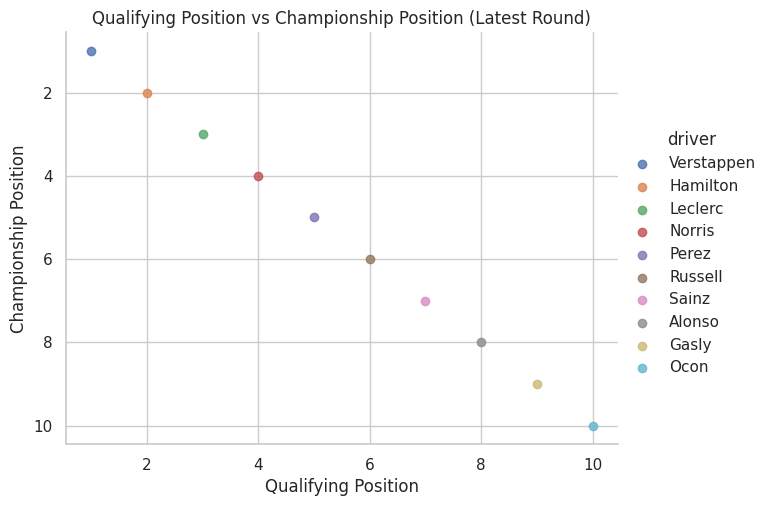

In [6]:
latest_round = qualifying_2023['round'].max()
latest_qual = qualifying_2023[qualifying_2023['round'] == latest_round]
latest_qual = latest_qual.merge(standings_2023[['driver', 'position']], how='left', on='driver')
sns.lmplot(data=latest_qual, x='position_x', y='position_y', hue='driver', height=5, aspect=1.3)
plt.title("Qualifying Position vs Championship Position (Latest Round)")
plt.xlabel("Qualifying Position")
plt.ylabel("Championship Position")
plt.gca().invert_yaxis()
plt.show()

 ## 🤖 Enhanced Top-3 Prediction Model


In [7]:
# 1. Aggregate Q3 average time per driver
qualifying_2023['q3_sec'] = qualifying_2023['q3'].apply(lambda t: float(t.split(':')[1]))
q3_avg = qualifying_2023.groupby('driver')['q3_sec'].mean().reset_index().rename(columns={'q3_sec': 'q3_sec_avg'})

# 2. Aggregate lap time variability per driver
lap_times_2023['time_sec'] = lap_times_2023['time'].apply(lambda t: float(t.split(':')[1]))
lap_std = lap_times_2023.groupby('driverId')['time_sec'].std().reset_index().rename(columns={'driverId': 'driver', 'time_sec': 'lap_variability'})
lap_std['driver'] = lap_std['driver'].str.capitalize()

# 3. Aggregate average pit stop duration per driver
pit_stops_2023['duration_sec'] = pit_stops_2023['duration'].astype(float)
pit_avg = pit_stops_2023.groupby('driver')['duration_sec'].mean().reset_index().rename(columns={'duration_sec': 'avg_pit_duration'})

# 4. Total points from standings
points_df = standings_2023[['driver', 'points']].rename(columns={'points': 'total_points'})

# 5. Target: top 3 classification
standings_2023['top3'] = standings_2023['position'] <= 3
target = standings_2023[['driver', 'top3']]

# Merge all features
features_df = q3_avg.merge(lap_std, on='driver').merge(pit_avg, on='driver').merge(points_df, on='driver').merge(target, on='driver')

# 6. Train/Test split and model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

X = features_df[['q3_sec_avg', 'lap_variability', 'avg_pit_duration', 'total_points']]
y = features_df['top3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Classification Report (Enhanced Model):")
print(classification_report(y_test, y_pred))

Classification Report (Enhanced Model):
              precision    recall  f1-score   support

       False       1.00      1.00      1.00         3

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



## 📈 Lap-by-Lap Position Evolution

In [8]:
lap_summary = lap_times_2023.groupby(['round', 'driverId'])['position'].mean().reset_index()
fig = px.line(lap_summary, x='round', y='position', color='driverId',
              title='Average Position per Round (Lap-by-Lap Evolution)')
fig.update_yaxes(autorange='reversed')
fig.show()

## ⚡ Fastest Lap Comparison (Simulated)

In [9]:
lap_times_2023['time_sec'] = lap_times_2023['time'].apply(lambda t: float(t.split(':')[1]))
fastest_laps = lap_times_2023.groupby(['round', 'driverId'])['time_sec'].min().reset_index()
fig = px.line(fastest_laps, x='round', y='time_sec', color='driverId', title='Fastest Lap Time per Driver per Round')
fig.show()

## ⏱️ Q3 Qualifying Time Trends

In [10]:
qualifying_2023['q3_sec'] = qualifying_2023['q3'].apply(lambda t: float(t.split(':')[1]))
q3_trends = qualifying_2023.groupby(['round', 'driver'])['q3_sec'].mean().reset_index()
fig = px.line(q3_trends, x='round', y='q3_sec', color='driver', title='Q3 Time Trends Across Rounds')
fig.show()

## 🎯 Finish vs Qualifying Position

In [11]:
qual_vs_pos = qualifying_2023.merge(standings_2023[['driver', 'position']], on='driver')
qual_vs_pos.rename(columns={'position_x': 'qual_position', 'position_y': 'champ_position'}, inplace=True)

fig = px.scatter(qual_vs_pos, x='qual_position', y='champ_position', color='driver',
                 title='Finish Position vs Qualifying Position (Merged)')
fig.update_yaxes(autorange='reversed')
fig.update_xaxes(title='Qualifying Position')
fig.update_yaxes(title='Championship Position')
fig.show()

## 🏟️ Circuit-wise Lap Time Distribution

In [12]:
lap_times_merged = lap_times_2023.merge(schedule_2023[['round', 'raceName']], on='round')
fig = px.box(lap_times_merged, x='raceName', y='time_sec', title='Lap Time Distribution by Circuit')
fig.update_layout(xaxis_title='Race', yaxis_title='Lap Time (sec)', xaxis_tickangle=-45)
fig.show()

## 📊 3D Clustering of Circuits (Simulated Metrics)

In [13]:
from sklearn.cluster import KMeans
circuit_metrics = pd.DataFrame({
    'circuit': schedule_2023['circuit'],
    'AvgSpeed': np.random.randint(180, 250, len(schedule_2023)),
    'AvgLaps': np.random.randint(45, 70, len(schedule_2023)),
    'AvgPitStops': np.round(np.random.uniform(1.5, 3.5, len(schedule_2023)), 1)
})
kmeans = KMeans(n_clusters=3, random_state=0).fit(circuit_metrics[['AvgSpeed', 'AvgLaps', 'AvgPitStops']])
circuit_metrics['Cluster'] = kmeans.labels_
fig = px.scatter_3d(circuit_metrics, x='AvgSpeed', y='AvgLaps', z='AvgPitStops',
                    color='Cluster', text='circuit', title='3D Circuit Clustering')
fig.show()